In [1]:
import re
import string 
import nltk 
from nltk.corpus import stopwords
from collections import defaultdict
from os import walk
import math
from matplotlib import pyplot as plt
import numpy as np

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
ptbr_stopwords = stopwords.words('portuguese')

[nltk_data] Downloading package punkt to /Users/jramos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jramos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Funções Auxiliares

In [3]:
def to_lower(text):
    return " ".join([w.lower() for w in text.split()])

In [4]:
def remove_punctuation(text):
    clean_txt = "".join([c for c in text if c not in string.punctuation+'º'])
    return clean_txt

In [5]:
def add_space(text):
    return '<s> <s> ' + text + ' </s> </s>'

In [6]:
def remove_stopwords(text):
    phrase = " ".join([w.lower() for w in text.split() if w not in ptbr_stopwords])
    return phrase

In [7]:
def preprocess(text):
    text = re.sub('\n\n', '\n', text)
    text = re.findall('(?<=<TEXT>)[\s\S]*?(?=<\/TEXT>)', text)
    treated_corpus = [[] for i in range(len(text))]
    for i in range(len(text)):
        text_bl = re.findall('(?<=\\n)[\s\S]*?(?=\\n)', text[i])
        for j in range(len(text_bl)):
            text_bl[j] = re.sub('(^[\s])|([\s]$)','',text_bl[j])
            text_point = re.findall('[^\.]+', text_bl[j])
            for k in range(len(text_point)):
                text_comma = re.findall('[^\;]+', text_point[k])
                for l in range(len(text_comma)):
                    text_comma[l] = re.sub('([\d+])','',text_comma[l])
                    text_comma[l] = re.sub('(^[\s])|([\s]$)','',text_comma[l])
                    text_comma[l] = to_lower(text_comma[l])
                    text_comma[l] = remove_stopwords(text_comma[l])
                    text_comma[l] = remove_punctuation(text_comma[l])
                    text_comma[l] = add_space(text_comma[l])
                    treated_corpus[i].append(text_comma[l])
    
    return treated_corpus

In [8]:
def make_three_gram(text, three_gram):

    words = text.split()
    for i in range(len(words) - 2):
        if (words[i], words[i+1]) in three_gram.keys():
            if words[i + 2] in three_gram[(words[i], words[i+1])].keys():
                three_gram[(words[i], words[i+1])][words[i + 2]] += 1
            else:
                three_gram[(words[i], words[i+1])][words[i + 2]] = 1
        else:
            three_gram[(words[i], words[i+1])] = {words[i + 2] : 1}
    
    return three_gram

In [9]:
def make_bi_gram(text, bi_gram):
    
    words = text.split()
    for i in range(len(words) - 2):
        if (words[i+1]) in bi_gram.keys():
            if words[i + 2] in bi_gram[(words[i+1])].keys():
                bi_gram[(words[i+1])][words[i + 2]] += 1
            else:
                bi_gram[(words[i+1])][words[i + 2]] = 1
        else:
            bi_gram[(words[i+1])] = {words[i + 2] : 1}
    
    return bi_gram

In [10]:
def make_uni_gram(text, uni_gram):

    words = text.split()
    for i in range(len(words) - 2):
        if words[i+2] in uni_gram.keys():
            uni_gram[words[i + 2]] += 1
        else:
            uni_gram[words[i + 2]] = 1
    
    return uni_gram

In [11]:
def probability(w3, sentence, three_gram, bi_gram, uni_gram):
    w1, w2 = sentence
    
    #print("W1: ", w1)
    #print("W2: ", w2)
    #print("W3: ", w3)
    
    try: 
        three_gram_prob = three_gram[(w1,w2)][w3] / bi_gram[w1][w2]
        bi_gram_prob = bi_gram[(w1)][w2] / uni_gram[w2]
        uni_gram_prob = uni_gram[w3] / len(uni_gram)
        final_prob = 0.8 * three_gram_prob * 0.15 * bi_gram_prob * 0.05 * uni_gram_prob
        return final_prob
    except KeyError:
        return 0

In [12]:
def makeGrams(corpus):

    
    three_gram = defaultdict()
    bi_gram = defaultdict()
    uni_gram = defaultdict()
        
    for txt in corpus:
        for p in txt:
            make_three_gram(p, three_gram)

    for txt in corpus:
        for p in txt:
            bi_gram = make_bi_gram(p, bi_gram)


    for txt in corpus:
        for p in txt:
            uni_gram = make_uni_gram(p, uni_gram)
            
    return uni_gram, bi_gram, three_gram

In [13]:
def makeCorpus(folder_name, n_data=None):
    files_arr = []
    for _, _, files in walk('./{}/'.format(folder_name)):
        files_arr.extend(files)
        break
    
    corpus = []
    for file_name in files_arr[:n_data]:
        f = open('{}/{}'.format(folder_name,file_name), encoding='latin-1', mode='r')
        text = f.read()
        corpus = corpus + preprocess(text)
        
    return corpus

In [14]:
def makeGramMask(sentence, n_gram_lvl=0):
    return makeGrams([[sentence]])[n_gram_lvl]

## Tratamento do Corpus

In [15]:
train_corpus = makeCorpus('folha95', 100)
test_corpus = makeCorpus('folha94', 100)

In [16]:
train_uni_gram, train_bi_gram, train_three_gram = makeGrams(train_corpus)

In [17]:
test_uni_gram,test_bi_gram, test_three_gram = makeGrams(test_corpus)

## Calculo da Perplexidade

In [18]:
perp_arr = {}
for text_tag in test_corpus:
    for sentence in text_tag:
        sentence_gram = makeGramMask(sentence, 2)
        #print(sentence)
        #print(sentence_gram)
        prob_sum = 0
        for word_tuple in sentence_gram.keys():
            for word in sentence_gram[word_tuple].keys():
                p = probability(word, word_tuple, train_three_gram, train_bi_gram, train_uni_gram)
                if p != 0:    
                    prob_sum = prob_sum + math.log(p)
        perp_arr[sentence] = math.exp(prob_sum)**(-1/float(len(sentence.split())))

# Discusão

## Perplexidade

### Análise
Abaixo está o grafico da perplexidade. É possivel identificar que existem perplexidades extreamente altas em comparação com o resto da distribuição.

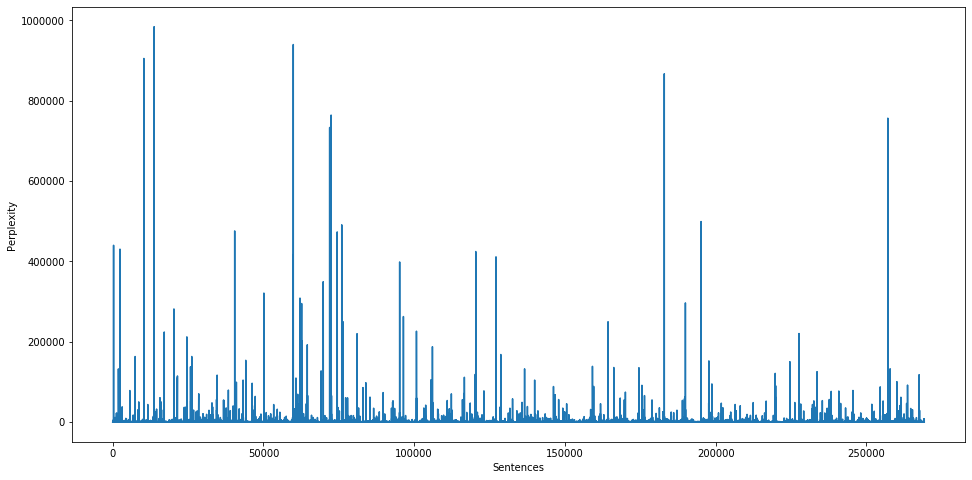

In [20]:
plt.figure(figsize=(16,8))
plt.xlabel('Sentences')
plt.ylabel('Perplexity')
plt.plot([i for i in range(len(perp_arr.keys()))], [perp_arr[k] for k in perp_arr.keys()])

Ao analisar algumas sentenças, é possível identificar que há uma grande aparição de nomes nas mesmas.

In [32]:
ar = []
for k in perp_arr.keys():
    if perp_arr[k] > 100000:
        ar.append(k)

Exemplo de 10 sentenças com Perplexidade maior que 100000

In [47]:
ar[:10]

['<s> <s> candido mendes  secretáriogeral comissão brasileira justiça paz presidente conselho superior ciências sociais unesco membro academia brasileira letras </s> </s>',
 '<s> <s> marcelo rubens paiva san francisco eua bolsista knight fellowship universidade standford </s> </s>',
 '<s> <s> paulo sérgio pinheiro  professor ciência política diretor núcleo estudos violência universidade paulo autor estratégias ilusão </s> </s>',
 '<s> <s> autor dona flor dois maridos gabriela cravo canela outros livros </s> </s>',
 '<s> <s> renato janine ribeiro  professor filosofia política universidade paulo autor a etiqueta antigo regime ao leitor medo brasiliense a última razão reis companhia letras </s> </s>',
 '<s> <s> renato lessa  cientista político diretor ensino instituto universitário pesquisa rio janeiro iuperj professor titular departamento ciência política universidade federal fluminense uff </s> </s>',
 '<s> <s> secretário especial assuntos econômicos ministério planejamento assessor ass

### Filtrando Perplexidade

In [49]:
filtered_perp = [perp_arr[k] for k in perp_arr.keys() if perp_arr[k] < 100000]

Aqui é mostrada a distribuição com o filtro de perplexidade em <100000

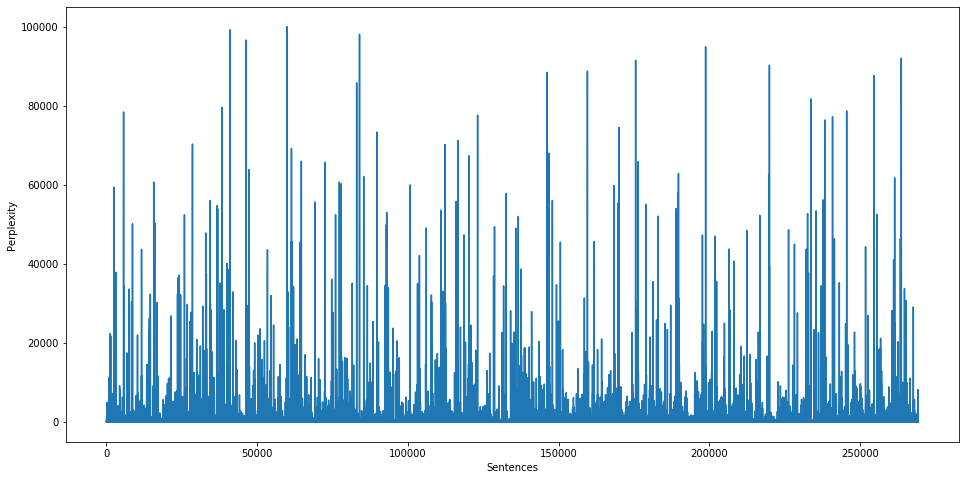

In [51]:
plt.figure(figsize=(16,8))
plt.xlabel('Sentences')
plt.ylabel('Perplexity')
plt.plot([i for i in range(len(filtered_perp))], [k for k in filtered_perp])